# 01_import dataset

## 01-1_import data

In [1]:
import os
import json
import pandas as pd

#https://drive.google.com/drive/folders/18qV82fNY3IIWu3BRoGqm_LNgJzE8Akbr?usp=drive_link
#base_dir = "/Users/Andypon/10_交大研究所/1141_01_機器學習與金融科技/data"
base_dir= '/Users/andyw.p.chen/Documents/Project/datasets'
#base_dir=  "c:\Users\user\Downloads\datasets"

def load_json_to_df(filename: str) -> pd.DataFrame:
    file_path = os.path.join(base_dir, filename)
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # 如果是 { "target": {id: value, ...} }
    if isinstance(data, dict) and len(data) == 1 and isinstance(next(iter(data.values())), dict):
        key, inner = next(iter(data.items()))
        return pd.DataFrame(list(inner.items()), columns=["id", key])

    # dict of scalar
    if isinstance(data, dict):
        return pd.DataFrame([{"code": k, "desc": v} for k, v in data.items()])

    # list of dict
    elif isinstance(data, list):
        return pd.DataFrame(data)

    else:
        raise ValueError(f"Unsupported JSON structure in {filename}: {type(data)}")


def load_csv_to_df(filename: str) -> pd.DataFrame:
    """讀取 CSV 並轉為 DataFrame。"""
    return pd.read_csv(os.path.join(base_dir, filename))

# JSON 資料
##mcc_codes_df = load_json_to_df("mcc_codes.json")
train_fraud_labels_df = load_json_to_df("train_fraud_labels.json")

# CSV 資料
cards_df = load_csv_to_df("cards_data.csv")
transactions_df = load_csv_to_df("transactions_data.csv")
users_df = load_csv_to_df("users_data.csv")

# 簡單檢查
#print(mcc_codes_df.head())
#print(train_fraud_labels_df.head())
#print(cards_df.head())
#print(transactions_df.head())
#print(users_df.apthead())


## 01-2_rename variable in each data set

In [2]:
train_fraud_labels_df = train_fraud_labels_df.rename(columns={'id': 'transactions_id'})
train_fraud_labels_df = train_fraud_labels_df.rename(columns={'target': 'is_fraud'})

cards_df = cards_df.rename(columns={'id':'card_id'})

users_df = users_df.rename(columns={'id':'client_id'})

transactions_df = transactions_df.rename(columns={'mcc': 'mcc_code'})
transactions_df = transactions_df.rename(columns={'id': 'transaction_id'})




## 01-3_變數型態統一及缺失值處理

In [3]:
def add_missing_flags(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    """
    在 DataFrame 中對指定欄位建立 missing flag 欄位
    flag=1 表示缺失值，flag=0 表示非缺失值
    
    參數
    ----
    df : pd.DataFrame
        輸入的資料框
    cols : list
        要檢查的欄位名稱清單
    
    回傳
    ----
    pd.DataFrame : 新的資料框 (含新增的 flag 欄位)
    """
    for col in cols:
        df[f"{col}_missing_flag"] = df[col].isna().astype(int)
    return df

transactions_df = add_missing_flags(transactions_df, ["merchant_state", "zip", "errors"])

In [4]:
##train_fraud_labels_df##
train_fraud_labels_df["is_fraud"]=train_fraud_labels_df["is_fraud"].astype("category") 
train_fraud_labels_df["transactions_id"]=train_fraud_labels_df["transactions_id"].astype(int) #合併資料需要

##cards_df##
cards_df["card_brand"]=cards_df["card_brand"].astype("category") 
cards_df["card_type"]=cards_df["card_type"].astype("category")
#####不要load這行 cards_df["expires"]=pd.to_datetime(cards_df["expires"], format="%m/%Y")
cards_df["expires"] = pd.to_datetime(cards_df["expires"], format="%m/%Y").dt.to_period("M")
cards_df["has_chip"]=cards_df["has_chip"].astype("category")

cards_df['credit_limit'] = cards_df['credit_limit'].replace(r'[\$,]', '', regex=True).astype(int)
#####不要load這行 cards_df["acct_open_date"]=pd.to_datetime(cards_df["acct_open_date"], format="%m/%Y")
cards_df["acct_open_date"] = pd.to_datetime(cards_df["acct_open_date"], format="%m/%Y").dt.to_period("M")
#####不要load這行 cards_df["year_pin_last_changed"]=pd.to_datetime(cards_df["year_pin_last_changed"], format="%Y")
cards_df["year_pin_last_changed"] = pd.to_datetime(cards_df["year_pin_last_changed"], format="%Y").dt.to_period("Y")
cards_df["card_on_dark_web"]=cards_df["card_on_dark_web"].astype("category") 

##users_df##
users_df["birth_year"] = pd.to_datetime(users_df["birth_year"], format="%Y").dt.to_period("Y")
users_df["birth_month"] = pd.to_datetime(users_df["birth_month"], format="%m").dt.to_period("M")
users_df["gender"]=users_df["gender"].astype("category") 
users_df['per_capita_income'] = users_df['per_capita_income'].replace(r'[\$,]', '', regex=True).astype(int)
users_df['yearly_income'] = users_df['yearly_income'].replace(r'[\$,]', '', regex=True).astype(int)
users_df['total_debt'] = users_df['total_debt'].replace(r'[\$,]', '', regex=True).astype(int)

##transactions_df##
transactions_df["date"] = pd.to_datetime(transactions_df["date"])
#浮點數轉整數原因確定？
transactions_df['amount'] = transactions_df['amount'].replace(r'[\$,]', '', regex=True).astype(float).astype(int)
##負數取log調成1
#transactions_df['amount'] = transactions_df['amount'].replace(r'[\$,]', '', regex=True).astype(float)

transactions_df["use_chip"]=transactions_df["use_chip"].astype("category") 

transactions_df.loc[
    transactions_df['merchant_city'].str.lower() == 'online',
    'merchant_state'
] = 'online'

transactions_df.loc[
    transactions_df['merchant_city'].str.lower() == 'online',
    'zip'
] = 20000 #原本是-1
## 我沒有全部改，這樣完之後仍有89006筆Missing，剩下都是在國外
transactions_df['zip'] = transactions_df['zip'].fillna(10000) #原本是-999
transactions_df["zip"]=transactions_df["zip"].astype("int64")

transactions_df['errors'] = transactions_df['errors'].astype('category')
transactions_df['errors'] = transactions_df['errors'].cat.add_categories('No_error').fillna('No_error')



In [5]:
#cars one hot encoding
##統一類別變數轉dummy variable(要注意共線性問題，應刪掉其中之一)

#card_type 原始種類：Debit_57%, Credit_33%, Debit(Prepaid)_9%
#card_brand 原始種類：MasterCard_52%, Visa_38%, Amex_7%, Discovery_3%
#has_chip 原始種類：Yes_89%, No_11%
#card_on_dark_web 原始種類：No_0%
cols_to_encode = ['card_type', 'card_brand', 'has_chip']
cards_df[cols_to_encode] = cards_df[cols_to_encode].astype('category')
dummies_cards = pd.get_dummies(
    cards_df[cols_to_encode], 
    prefix=cols_to_encode, 
    dtype='uint8'
    )
cards_df = pd.concat([cards_df, dummies_cards], axis=1)

#use_chip 原始種類：Swiped_52%, Chipe_36%, Online_12%
dummies_use = pd.get_dummies(transactions_df['use_chip'], prefix='use_chip', dtype='uint8')
transactions_df = pd.concat([transactions_df, dummies_use], axis=1)

#gender 原始種類：Female_51%, Male_49%
dummies_gender = pd.get_dummies(users_df['gender'], prefix='gender', dtype='uint8')
users_df = pd.concat([users_df, dummies_gender], axis=1)


cards_df.drop(columns=["has_chip_NO","has_chip"], inplace=True)
transactions_df.drop(columns=["use_chip"], inplace=True)
users_df.drop(columns=["gender_Female"], inplace=True)

## 01-4_測試用code

In [6]:
##不用執行～～(本來試圖建立對照表將Missing的zip補上)

##檢查89006筆Missing的zip
c_missing_zip = transactions_df[transactions_df["zip"].isna()]
c_mexico_zip = transactions_df[transactions_df["merchant_state"]=="Mexico"]
#c_mcc_mv_zip = c_missing_zip[
#    (c_missing_zip["mcc_code"] > 5400) & (c_missing_zip["mcc_code"] < 5700)
#]



# 先建立 mapping table：一組 state+city 可能對應多個 zip
mapping_df = (
    transactions_df
    .dropna(subset=["zip"])                                   # 只要 zip 有值的 row
    .drop_duplicates(subset=["merchant_state", "merchant_city", "zip"]) 
    [["merchant_state", "merchant_city", "zip"]]              # 只留下需要的欄位
)

print(mapping_df.head())


# 假設 df 已經存在
# 建立新的欄位 F，B 與 C 合併
c_missing_zip["fullname"] = c_missing_zip["merchant_city"].astype(str) + c_missing_zip["merchant_state"].astype(str)
# 建立新的 DataFrame，只取 A, D, F
df_small = c_missing_zip[["transaction_id", "fullname","zip"]]

mapping_df["mfullname"] = mapping_df["merchant_city"].astype(str) + mapping_df["merchant_state"].astype(str)

# 先建立一個 lookup 字典
lookup_dict = dict(zip(mapping_df["mfullname"], mapping_df["zip"]))

# 用 map 當作 vlookup
df_small["zip"] = df_small["zip"].fillna(df_small["fullname"].map(lookup_dict))




  merchant_state merchant_city    zip
0             ND        Beulah  58523
1             IA    Bettendorf  52722
2             CA         Vista  92084
3             IN   Crown Point  46307
4             MD       Harwood  20776


# 02_資料整併成一張dataframe

## 02-1_資料整併

In [7]:
#transactions_df.loc[transactions_df["transaction_id"] == 10649266] #transaction_id vs id

#原始資料筆數：13305915
### transactions_df+train_fraud_labels_df      left 會有4390952 missing values
merged = pd.merge(transactions_df, train_fraud_labels_df, left_on="transaction_id", right_on="transactions_id", how="outer")
### transactions_df train_fraud_labels_df(8914963) + users_df 對過去不會有missing values
merged = pd.merge(merged,users_df , left_on="client_id", right_on="client_id", how="left")
### transactions_df train_fraud_labels_df users_df + cards_df 對過去不會有missing values
merged = pd.merge(merged,cards_df , left_on="card_id", right_on="card_id", how="left")

#刪掉重複的columns
merged.drop(columns=["transactions_id"], inplace=True)
merged.drop(columns=["client_id_y"], inplace=True)

## 合併完之後最後處理is_fraud(原會有missing values問題)
merged["is_fraud"] = merged["is_fraud"].astype(str)
merged.loc[merged['is_fraud'].str.lower() == 'no','is_fraud'] = '0'
merged.loc[merged['is_fraud'].str.lower() == 'yes','is_fraud'] = '1'
merged["is_fraud"] = pd.to_numeric(merged["is_fraud"], errors="coerce").astype("Int64")

merged = add_missing_flags(merged, ["is_fraud"])

#merged.to_csv("merged.csv", index=False)

# 先刪除不需要的DataFrame以節省記憶體
del transactions_df, users_df, cards_df, train_fraud_labels_df, cols_to_encode, dummies_cards, dummies_use, dummies_gender

In [8]:
del mapping_df, c_missing_zip, c_mexico_zip, df_small, lookup_dict
backup_merged = merged.copy()
#merged = backup_merged.copy()

# 03_EDA_Exploratory-Data-Analysis

## 03-1_資料型態

merged資料：8914963x37

In [ ]:
merged.info()

## 03-2_資料統計指標

In [ ]:
merged.describe()

In [ ]:
merged.describe(include='all')

## 03-3_類別型資料frequency barchart

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cat_cols = merged.select_dtypes(include=["category"]).columns

n_rows, n_cols = 4, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 50))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    ax = axes[i]
    sns.countplot(data=merged, x=col, order=merged[col].value_counts().index, ax=ax)
    ax.set_title(f"Bar chart of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    if col == "errors":
        ax.tick_params(axis='x', rotation=90)  # X軸標籤旋轉
    else:
        ax.tick_params(axis='x', rotation=0)  # X軸標籤旋轉
    
    # 在長條圖上加數字
    for p in ax.patches:
        height = p.get_height()
        ax.text(x=p.get_x() + p.get_width()/2,
                y=height + 0.05,
                s=int(height),
                ha='center')

# 移除多餘空白子圖
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## 03-4_數值型資料histogram

In [ ]:
# 設定 subplot 格式
n_cols = 4   # 每列放4張圖
n_rows = 6   # 每行放6列 (共 4x6=24)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,15))  # 調整大小
axes = axes.flatten()  # 攤平成一維方便迭代
num_cols = merged.select_dtypes(include=['int64', 'float64']).columns

for i, col in enumerate(num_cols):
    sns.histplot(data=merged, x=col, bins=30, kde=True, ax=axes[i])
    axes[i].set_title(col)

# 把多餘的 subplot 關掉（避免空白框）
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 03-5_類別型資料box plot

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 抓出數值型欄位
num_cols = merged.select_dtypes(include=['int64', 'float64']).columns

# 建立 3x8 subplot
fig, axes = plt.subplots(8, 3, figsize=(30, 50))  # 依照需求調整 figsize
axes = axes.flatten()  # 攤平成一維 array，方便迴圈

# 逐一畫圖
for i, col in enumerate(num_cols):
    sns.boxplot(y=merged[col], ax=axes[i])  # 每個 subplot 畫一個 boxplot
    axes[i].set_title(col, fontsize=10)

# 如果欄位數小於 3x8，隱藏多餘的子圖
for j in range(len(num_cols), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


## 03-6_數值型資料pair wise scatterplot(畫不出來？)

In [ ]:
num_cols = merged.select_dtypes(include=['int64', 'float64']).columns
sns.pairplot(merged[num_cols])

## 03-7_針對時間轉換資料

In [12]:
mask = (merged["date"] >= "2018-01-01 00:00:00") & (merged["date"] <= "2019-10-31 23:59:59")
merged = merged[mask]


In [ ]:
merged.drop(columns=["weekday","hour","is_fraud_missing_flag"], inplace=True)

In [ ]:
merged["is_fraud"]=merged["is_fraud"].astype("int64")
target = 'is_fraud'  # 假設這是目標
num_cols = merged.select_dtypes(include=['int64','float64']).columns.drop(target)

for col in num_cols:
    plt.figure(figsize=(5,4))
    plt.scatter(merged[col], merged[target], alpha=0.3)  # alpha降低透明度，避免太擠
    plt.xlabel(col)
    plt.ylabel(target)
    plt.title(f"{target} vs {col}")
    plt.show()

## 03-8_其他觀察 詐騙與否跟時間的關係

/Users/andyw.p.chen/Documents/Project/2025_Fraud-Detection-project/virtual/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andyw.p.chen/Documents/Project/2025_Fraud-Detection-project/virtual/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andyw.p.chen/Documents/Project/2025_Fraud-Detection-project/virtual/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35408 (\N{CJK UNIFIED IDEOGRAPH-8A50}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andyw.p.chen/Documents/Project/2025_Fraud-Detection-project/virtual/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39449 (\N{CJK UNIFIED IDEOGRAPH-9A1

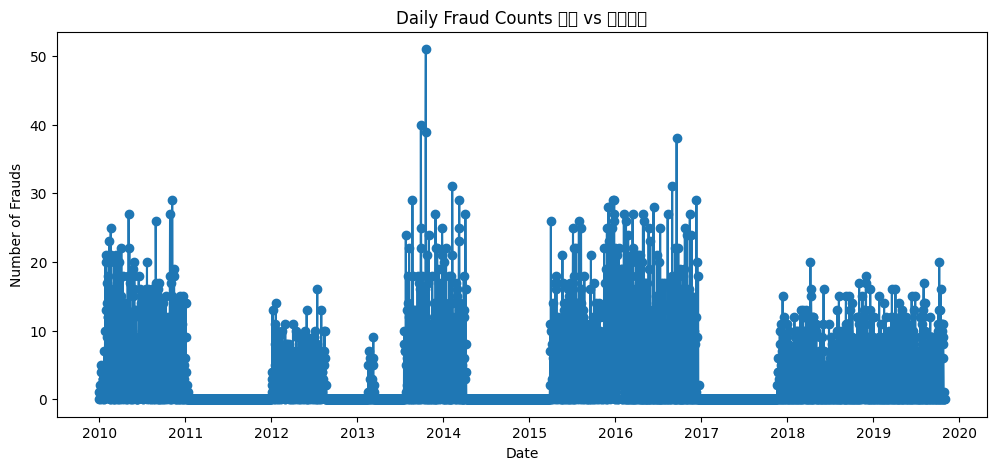

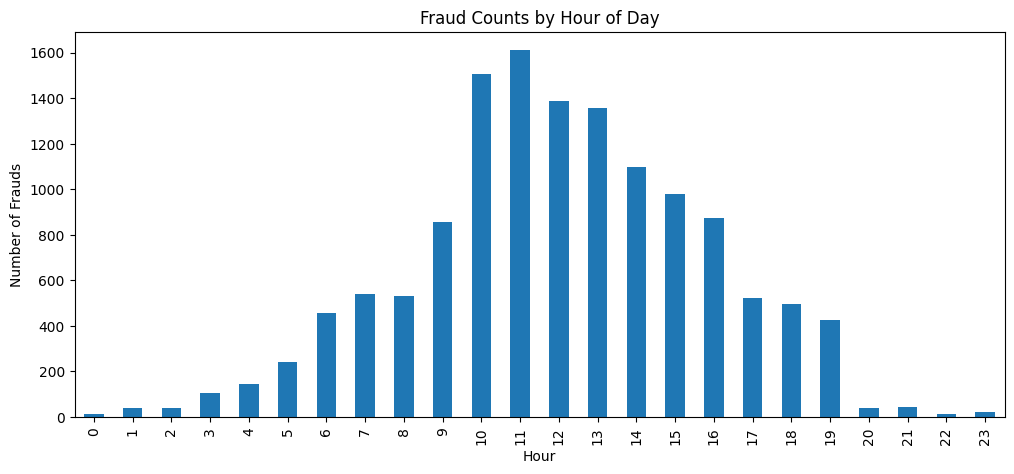

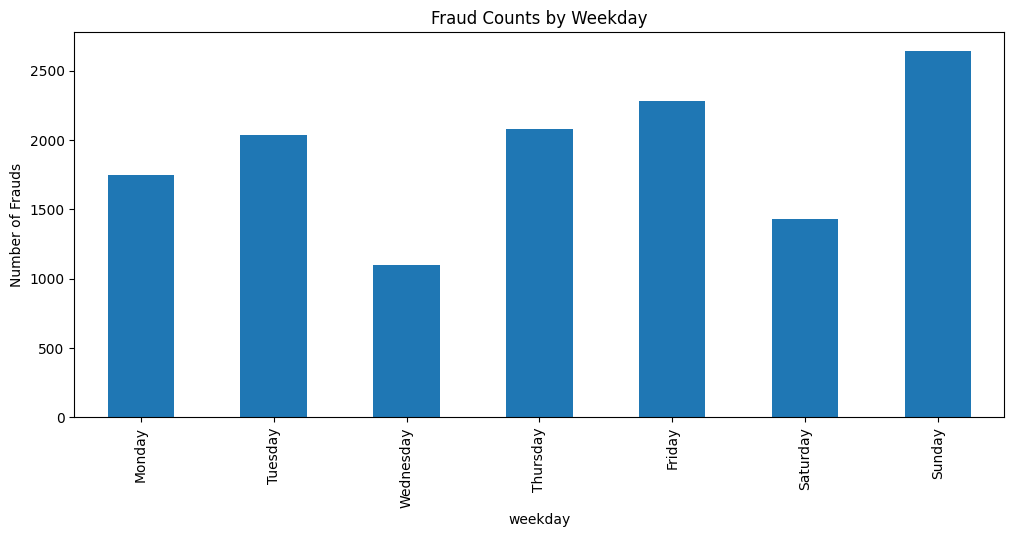

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# 確保 date 是 datetime 格式
merged["date"] = pd.to_datetime(merged["date"])

# 按天統計詐騙事件數
fraud_per_day = merged.groupby(merged["date"].dt.date)["is_fraud"].sum()

# 畫折線圖
plt.figure(figsize=(12,5))
fraud_per_day.plot(kind="line", marker="o")
plt.title("Daily Fraud Counts 日期 vs 詐騙次數")
plt.xlabel("Date")
plt.ylabel("Number of Frauds")
plt.show()


# 按小時
merged["hour"] = merged["date"].dt.hour
hourly_fraud = merged.groupby("hour")["is_fraud"].sum()

plt.figure(figsize=(12,5))
hourly_fraud.plot(kind="bar")
plt.title("Fraud Counts by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Frauds")
plt.show()

# 按星期幾
merged["weekday"] = merged["date"].dt.day_name()
weekday_fraud = merged.groupby("weekday")["is_fraud"].sum().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
)

plt.figure(figsize=(12,5))
weekday_fraud.plot(kind="bar")
plt.title("Fraud Counts by Weekday")
plt.ylabel("Number of Frauds")
plt.show()



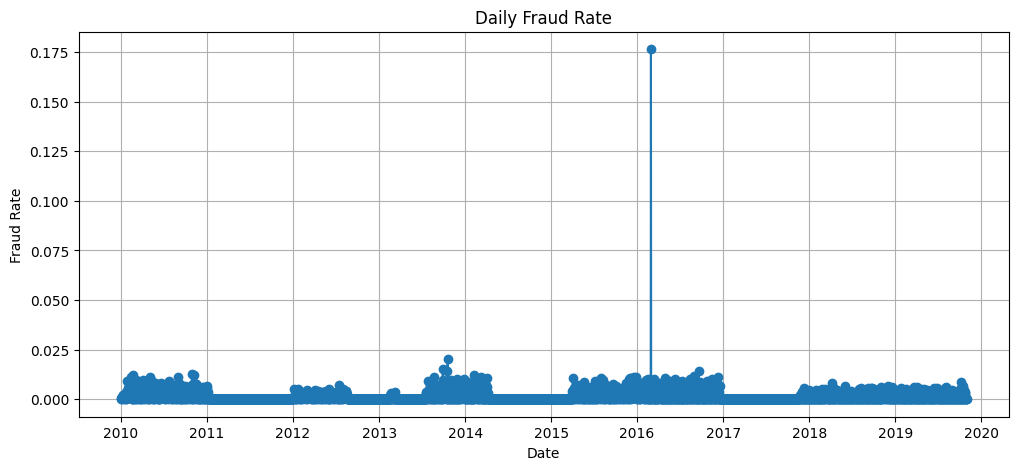

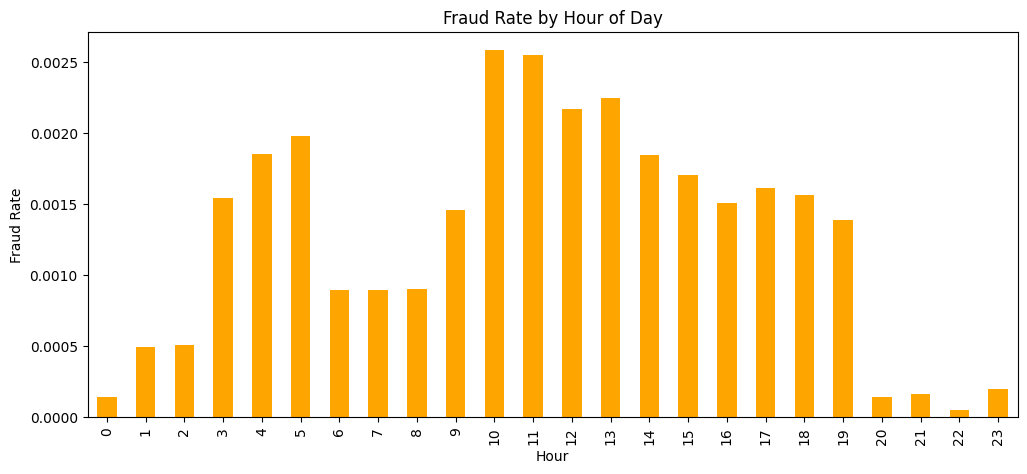

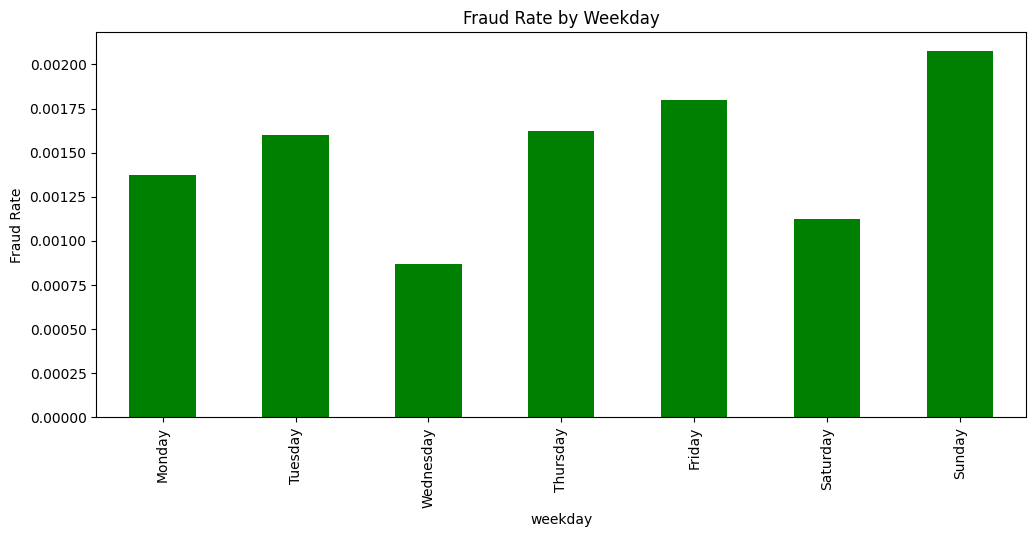

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# 確保日期格式正確
merged["date"] = pd.to_datetime(merged["date"])

### 1️⃣ 每日詐騙率 ###
daily_stats = merged.groupby(merged["date"].dt.date)["is_fraud"].agg(["sum", "count"])
daily_stats["fraud_rate"] = daily_stats["sum"] / daily_stats["count"]

plt.figure(figsize=(12,5))
plt.plot(daily_stats.index, daily_stats["fraud_rate"], marker="o")
plt.title("Daily Fraud Rate")
plt.xlabel("Date")
plt.ylabel("Fraud Rate")
plt.grid(True)
plt.show()


### 2️⃣ 每小時詐騙率 ###
merged["hour"] = merged["date"].dt.hour
hourly_stats = merged.groupby("hour")["is_fraud"].agg(["sum", "count"])
hourly_stats["fraud_rate"] = hourly_stats["sum"] / hourly_stats["count"]

plt.figure(figsize=(12,5))
hourly_stats["fraud_rate"].plot(kind="bar", color="orange")
plt.title("Fraud Rate by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Fraud Rate")
plt.show()


### 3️⃣ 每星期詐騙率 ###
merged["weekday"] = merged["date"].dt.day_name()
weekday_stats = merged.groupby("weekday")["is_fraud"].agg(["sum", "count"])
weekday_stats["fraud_rate"] = weekday_stats["sum"] / weekday_stats["count"]

# 依星期順序重新排列
weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
weekday_stats = weekday_stats.reindex(weekday_order)

plt.figure(figsize=(12,5))
weekday_stats["fraud_rate"].plot(kind="bar", color="green")
plt.title("Fraud Rate by Weekday")
plt.ylabel("Fraud Rate")
plt.show()


In [16]:
# 找出詐騙率最高的一天
max_fraud_day = daily_stats["fraud_rate"].idxmax()
max_fraud_rate = daily_stats.loc[max_fraud_day, "fraud_rate"]

print(f"📅 詐騙率最高的日期是 {max_fraud_day}，詐騙率為 {max_fraud_rate:.2%}")

📅 詐騙率最高的日期是 2016-02-29，詐騙率為 17.65%


📅 排除日期：2016-02-29（詐騙率 17.65%）
原始資料筆數：13305915
排除後資料筆數：13305893


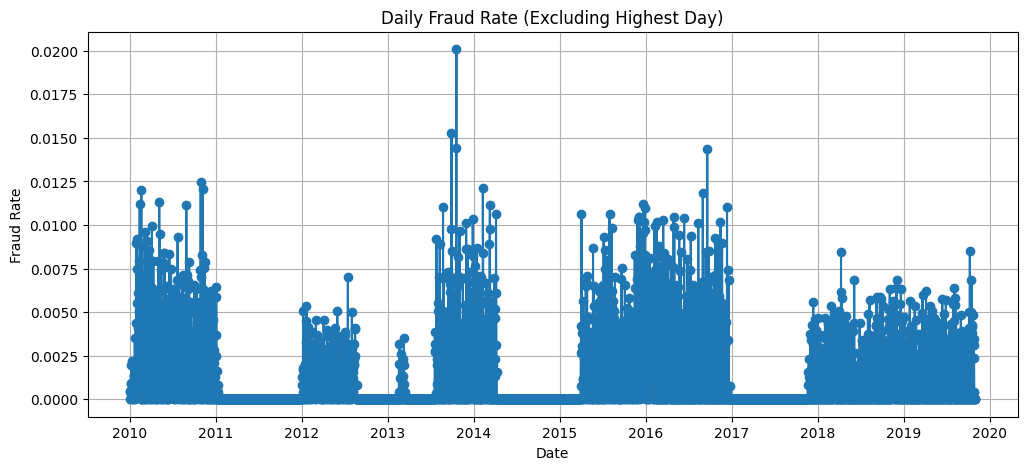

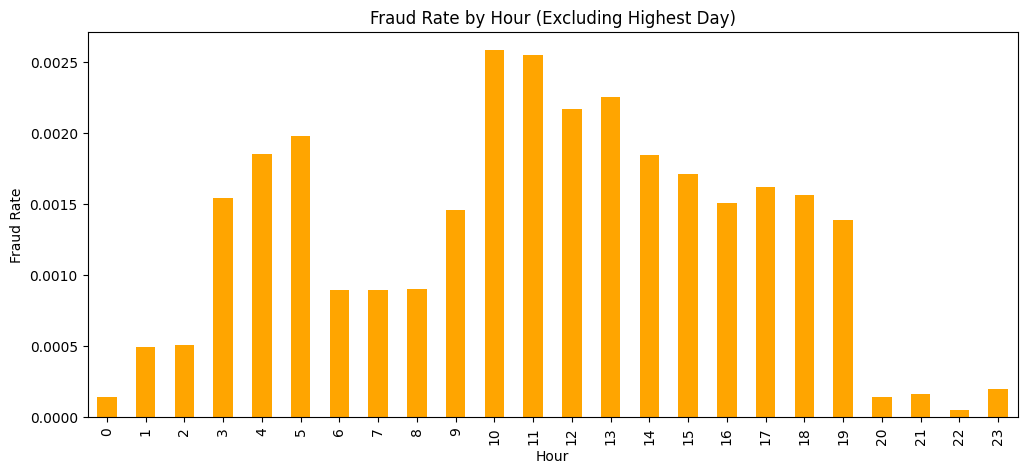

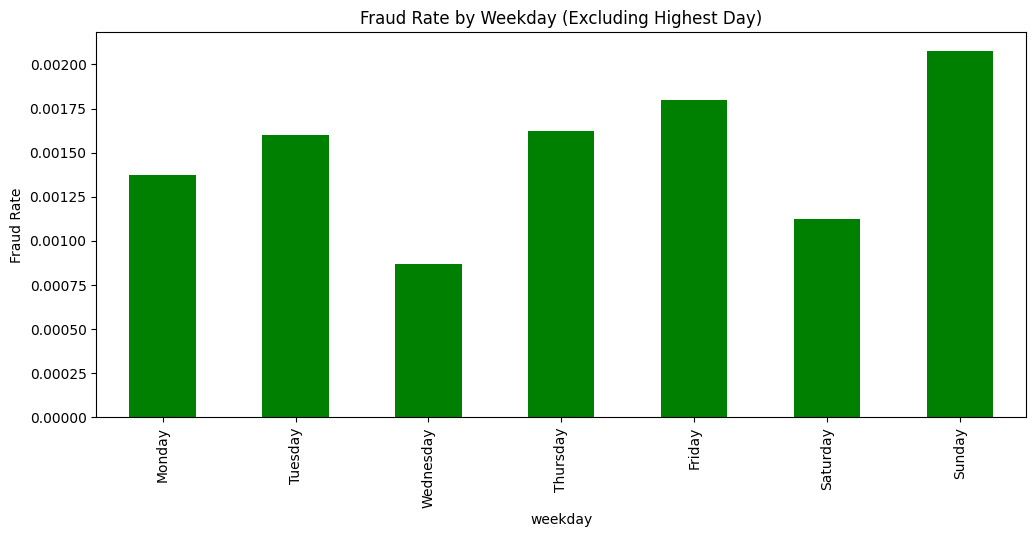

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# 確保日期格式正確
merged["date"] = pd.to_datetime(merged["date"])

### Step 1️⃣：計算每日詐騙率 ###
daily_stats = merged.groupby(merged["date"].dt.date)["is_fraud"].agg(["sum", "count"])
daily_stats["fraud_rate"] = daily_stats["sum"] / daily_stats["count"]

# 找出詐騙率最高的那一天
max_fraud_day = daily_stats["fraud_rate"].idxmax()
max_fraud_rate = daily_stats.loc[max_fraud_day, "fraud_rate"]
print(f"📅 排除日期：{max_fraud_day}（詐騙率 {max_fraud_rate:.2%}）")

### Step 2️⃣：建立不含異常日的副本 ###
merged_no_outlier = merged[merged["date"].dt.date != max_fraud_day].copy()

print(f"原始資料筆數：{len(merged)}")
print(f"排除後資料筆數：{len(merged_no_outlier)}")

# ───────────────────────────────
# 重新進行三種詐騙率分析
# ───────────────────────────────

### (A) 每日詐騙率 ###
daily_stats_no_outlier = merged_no_outlier.groupby(merged_no_outlier["date"].dt.date)["is_fraud"].agg(["sum", "count"])
daily_stats_no_outlier["fraud_rate"] = daily_stats_no_outlier["sum"] / daily_stats_no_outlier["count"]

plt.figure(figsize=(12,5))
plt.plot(daily_stats_no_outlier.index, daily_stats_no_outlier["fraud_rate"], marker="o")
plt.title("Daily Fraud Rate (Excluding Highest Day)")
plt.xlabel("Date")
plt.ylabel("Fraud Rate")
plt.grid(True)
plt.show()


### (B) 每小時詐騙率 ###
merged_no_outlier["hour"] = merged_no_outlier["date"].dt.hour
hourly_stats_no_outlier = merged_no_outlier.groupby("hour")["is_fraud"].agg(["sum", "count"])
hourly_stats_no_outlier["fraud_rate"] = hourly_stats_no_outlier["sum"] / hourly_stats_no_outlier["count"]

plt.figure(figsize=(12,5))
hourly_stats_no_outlier["fraud_rate"].plot(kind="bar", color="orange")
plt.title("Fraud Rate by Hour (Excluding Highest Day)")
plt.xlabel("Hour")
plt.ylabel("Fraud Rate")
plt.show()


### (C) 每星期詐騙率 ###
merged_no_outlier["weekday"] = merged_no_outlier["date"].dt.day_name()
weekday_stats_no_outlier = merged_no_outlier.groupby("weekday")["is_fraud"].agg(["sum", "count"])
weekday_stats_no_outlier["fraud_rate"] = weekday_stats_no_outlier["sum"] / weekday_stats_no_outlier["count"]

weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
weekday_stats_no_outlier = weekday_stats_no_outlier.reindex(weekday_order)

plt.figure(figsize=(12,5))
weekday_stats_no_outlier["fraud_rate"].plot(kind="bar", color="green")
plt.title("Fraud Rate by Weekday (Excluding Highest Day)")
plt.ylabel("Fraud Rate")
plt.show()


In [21]:
merged.columns

Index(['transaction_id', 'date', 'client_id_x', 'card_id', 'amount',
       'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc_code',
       'errors', 'merchant_state_missing_flag', 'zip_missing_flag',
       'errors_missing_flag', 'use_chip_Chip Transaction',
       'use_chip_Online Transaction', 'use_chip_Swipe Transaction', 'is_fraud',
       'current_age', 'retirement_age', 'birth_year', 'birth_month', 'gender',
       'address', 'latitude', 'longitude', 'per_capita_income',
       'yearly_income', 'total_debt', 'credit_score', 'num_credit_cards',
       'gender_Male', 'card_brand', 'card_type', 'card_number', 'expires',
       'cvv', 'num_cards_issued', 'credit_limit', 'acct_open_date',
       'year_pin_last_changed', 'card_on_dark_web', 'card_type_Credit',
       'card_type_Debit', 'card_type_Debit (Prepaid)', 'card_brand_Amex',
       'card_brand_Discover', 'card_brand_Mastercard', 'card_brand_Visa',
       'has_chip_YES', 'is_fraud_missing_flag', 'hour', 'weekday'],


## 03-9_correlation and heatmap

In [ ]:
numeric_df = merged.select_dtypes(include=['int64', 'float64'])
corr = numeric_df.corr()
print(corr)

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Numeric Variables")
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
# --- 原始資料 correlation ---
corr_raw = numeric_df.corr()

# --- 標準化後 correlation ---
scaler = StandardScaler()
num_scaled = scaler.fit_transform(numeric_df)   # 轉換成 Numpy array
num_df_scaled = pd.DataFrame(num_scaled, columns=numeric_df.columns)
corr_scaled = num_df_scaled.corr()

# --- 繪圖 (上下對照) ---
fig, axes = plt.subplots(2, 1, figsize=(12, 14))

sns.heatmap(corr_raw, annot=True, fmt=".2f", cmap="coolwarm", center=0, ax=axes[0])
axes[0].set_title("Correlation Heatmap (Raw Data)")

sns.heatmap(corr_scaled, annot=True, fmt=".2f", cmap="coolwarm", center=0, ax=axes[1])
axes[1].set_title("Correlation Heatmap (Standardized Data)")

plt.tight_layout()
plt.show()

## 03-99_categoracal 轉 dummy分析_(不用執行)

In [ ]:
info_df = pd.DataFrame({
    "column": merged.columns,
    "dtype": merged.dtypes.astype(str)
})
info_df.to_csv("info.csv", index=False)

# 04_Benchmark model(no any adjustment)

## 04-1_資料進行變數轉換以求模型配飾更佳表現

In [22]:
#merged = merged[merged["merchant_city"] != "ONLINE"]
merged = backup_merged.copy()
mask = (merged["date"] >= "2017-01-01 00:00:00") & (merged["date"] <= "2018-12-31 23:59:59")
finding = merged[mask]

## 04-2_分割訓練集及測試集

In [9]:
#選取數值型變數
num_cols = merged.select_dtypes(include=['int64', 'float64','uint8']).columns
df=merged[num_cols]
#dropna
df_cleaned = df.dropna()
del df
#避免共線性
df_cleaned.drop(columns=["is_fraud_missing_flag","card_type_Debit (Prepaid)", "card_brand_Discover", "use_chip_Online Transaction"], inplace=True)
#分割訓練集及測試集
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df_cleaned, test_size=0.2, random_state=888)

#確認資料分布情形
del df_cleaned, merged
print(train_df['is_fraud'].value_counts(normalize=False))
print(test_df['is_fraud'].value_counts(normalize=False))

is_fraud
0    7121379
1      10591
Name: count, dtype: Int64
is_fraud
0    1780252
1       2741
Name: count, dtype: Int64


## 04-5(a)_ Model BY SkLEARN

In [ ]:
train_df.columns


Index(['transaction_id', 'client_id_x', 'card_id', 'amount', 'merchant_id',
       'zip', 'mcc_code', 'merchant_state_missing_flag', 'zip_missing_flag',
       'errors_missing_flag', 'use_chip_Chip Transaction',
       'use_chip_Swipe Transaction', 'is_fraud', 'current_age',
       'retirement_age', 'latitude', 'longitude', 'per_capita_income',
       'yearly_income', 'total_debt', 'credit_score', 'num_credit_cards',
       'gender_Male', 'card_number', 'cvv', 'num_cards_issued', 'credit_limit',
       'card_type_Credit', 'card_type_Debit', 'card_brand_Amex',
       'card_brand_Mastercard', 'card_brand_Visa', 'has_chip_YES'],
      dtype='object')

=== 訓練集 (Train) 結果 ===
    Cutoff     TP       FP       TN     FN  Specificity  Sensitivity  \
0     0.00  10591  7121379        0      0     0.000000     1.000000   
1     0.05   2276    19712  7101667   8315     0.997232     0.214899   
2     0.10   1137     6027  7115352   9454     0.999154     0.107355   
3     0.15    455     1776  7119603  10136     0.999751     0.042961   
4     0.20    215      617  7120762  10376     0.999913     0.020300   
5     0.25    117      274  7121105  10474     0.999962     0.011047   
6     0.30     86      156  7121223  10505     0.999978     0.008120   
7     0.35     63      100  7121279  10528     0.999986     0.005948   
8     0.40     54       68  7121311  10537     0.999990     0.005099   
9     0.45     47       60  7121319  10544     0.999992     0.004438   
10    0.50     43       56  7121323  10548     0.999992     0.004060   
11    0.55     37       52  7121327  10554     0.999993     0.003494   
12    0.60     30       47  7121332  1056

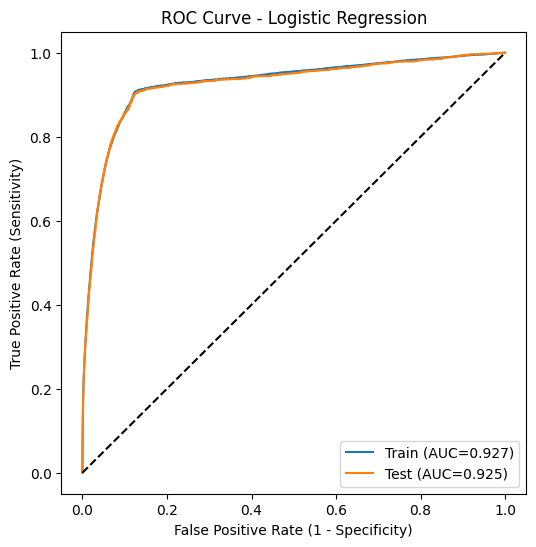

AUC (Train): 0.9271
AUC (Test):  0.9250

最佳cutoff (Train, 依Youden最大):
Cutoff         5.000000e-02
TP             2.276000e+03
FP             1.971200e+04
TN             7.101667e+06
FN             8.315000e+03
Specificity    9.972320e-01
Sensitivity    2.148994e-01
Youden         2.121314e-01
F1             1.397219e-01
Accuracy       9.960702e-01
Name: 1, dtype: float64

最佳cutoff (Test, 依Youden最大):
Cutoff         5.000000e-02
TP             5.860000e+02
FP             4.829000e+03
TN             1.775423e+06
FN             2.155000e+03
Specificity    9.972875e-01
Sensitivity    2.137906e-01
Youden         2.110781e-01
F1             1.436979e-01
Accuracy       9.960830e-01
Name: 1, dtype: float64


In [13]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, roc_curve, roc_auc_score, f1_score, accuracy_score
)
import matplotlib.pyplot as plt

# ============================================================
# 1️⃣ 資料切分與前處理
# ============================================================
X_train = train_df.drop(columns=['is_fraud'])
y_train = train_df['is_fraud']

X_test = test_df.drop(columns=['is_fraud'])
y_test = test_df['is_fraud']

# 若有類別變數，轉為虛擬變數
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 確保兩邊欄位一致
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# 特徵標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ============================================================
# 2️⃣ 模型訓練 (Logistic Regression)
# ============================================================
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# 機率預測
y_prob_train = model.predict_proba(X_train_scaled)[:, 1]
y_prob_test = model.predict_proba(X_test_scaled)[:, 1]

# ============================================================
# 3️⃣ 定義評估函式
# ============================================================
def evaluate_cutoff(y_true, y_prob, cutoff):
    y_pred = (y_prob >= cutoff).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    youden = sensitivity + specificity - 1
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    return {
        "Cutoff": cutoff,
        "TP": tp, "FP": fp, "TN": tn, "FN": fn,
        "Specificity": specificity,
        "Sensitivity": sensitivity,
        "Youden": youden,
        "F1": f1,
        "Accuracy": acc
    }

# ============================================================
# 4️⃣ 計算不同cutoff下的評估指標
# ============================================================
cutoffs = np.arange(0.0, 1.01, 0.05)
train_results = [evaluate_cutoff(y_train, y_prob_train, c) for c in cutoffs]
test_results = [evaluate_cutoff(y_test, y_prob_test, c) for c in cutoffs]

train_df_metrics = pd.DataFrame(train_results)
test_df_metrics = pd.DataFrame(test_results)

print("=== 訓練集 (Train) 結果 ===")
print(train_df_metrics)
print("\n=== 測試集 (Test) 結果 ===")
print(test_df_metrics)

# ============================================================
# 5️⃣ ROC曲線 & AUC
# ============================================================
def plot_roc(y_true, y_prob, label):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f})")
    return auc

plt.figure(figsize=(6,6))
auc_train = plot_roc(y_train, y_prob_train, "Train")
auc_test = plot_roc(y_test, y_prob_test, "Test")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()

print(f"AUC (Train): {auc_train:.4f}")
print(f"AUC (Test):  {auc_test:.4f}")

# ============================================================
# 6️⃣ 顯示最佳cutoff（依Youden）
# ============================================================
best_cut_train = train_df_metrics.loc[train_df_metrics['Youden'].idxmax()]
best_cut_test = test_df_metrics.loc[test_df_metrics['Youden'].idxmax()]

print("\n最佳cutoff (Train, 依Youden最大):")
print(best_cut_train)

print("\n最佳cutoff (Test, 依Youden最大):")
print(best_cut_test)


In [21]:
# ============================================================
# 4️⃣ 計算不同cutoff下的評估指標
# ============================================================

cutoffs = [round(x, 5) for x in np.arange(0.0001, 0.001, 0.0001)]  # 0 ~ 0.2 間隔 0.02
#cutoffs += [round(x, 5) for x in np.arange(0.11, 1, 0.1)]  # 0.3 ~ 1 間隔 0.1
#train_results = [evaluate_cutoff(y_train, y_prob_train, c) for c in cutoffs]
test_results = [evaluate_cutoff(y_test, y_prob_test, c) for c in cutoffs]

#train_df_metrics = pd.DataFrame(train_results)
test_df_metrics = pd.DataFrame(test_results)

#print("=== 訓練集 (Train) 結果 ===")
#print(train_df_metrics)
print("\n=== 測試集 (Test) 結果 ===")
print(test_df_metrics)


=== 測試集 (Test) 結果 ===
   Cutoff    TP       FP       TN   FN  Specificity  Sensitivity    Youden  \
0  0.0001  2651  1166639   613613   90     0.344678     0.967165  0.311843   
1  0.0002  2572   669867  1110385  169     0.623723     0.938344  0.562067   
2  0.0003  2541   442189  1338063  200     0.751614     0.927034  0.678648   
3  0.0004  2517   328807  1451445  224     0.815303     0.918278  0.733581   
4  0.0005  2506   274034  1506218  235     0.846070     0.914265  0.760335   
5  0.0006  2490   247254  1532998  251     0.861113     0.908428  0.769541   
6  0.0007  2487   233996  1546256  254     0.868560     0.907333  0.775893   
7  0.0008  2477   227423  1552829  264     0.872252     0.903685  0.775937   
8  0.0009  2474   223707  1556545  267     0.874340     0.902590  0.776930   

         F1  Accuracy  
0  0.004524  0.345635  
1  0.007619  0.624207  
2  0.011357  0.751884  
3  0.015069  0.815461  
4  0.017946  0.846175  
5  0.019724  0.861186  
6  0.020792  0.868620  
7  0

In [20]:
test_df_metrics

,Cutoff,TP,FP,TN,FN,Specificity,Sensitivity,Youden,F1,Accuracy
0,0.001,2470,221367,1558885,271,0.875654,0.901131,0.776785,0.021803,0.875693
1,0.002,2445,211255,1568997,296,0.881334,0.892010,0.773344,0.022593,0.881351
2,0.003,2401,199605,1580647,340,0.887878,0.875958,0.763836,0.023453,0.887860
3,0.004,2345,179810,1600442,396,0.898997,0.855527,0.754525,0.025366,0.898931
4,0.005,2284,155157,1625095,457,0.912845,0.833273,0.746118,0.028518,0.912723
...,...,...,...,...,...,...,...,...,...,...
94,0.095,327,1597,1778655,2414,0.999103,0.119300,0.118402,0.140193,0.997750
95,0.096,322,1559,1778693,2419,0.999124,0.117475,0.116600,0.139334,0.997769
96,0.097,320,1510,1778742,2421,0.999152,0.116746,0.115898,0.140013,0.997795
97,0.098,316,1460,1778792,2425,0.999180,0.115286,0.114466,0.139916,0.997821


# 05_地區分析

驚人發現 "2018-01-01 00:00:00" 到 "2019-10-31 23:59:59"的交易資料中，詐騙高度集中在網路交易、境外交易、ohio州

In [63]:
df=train_df

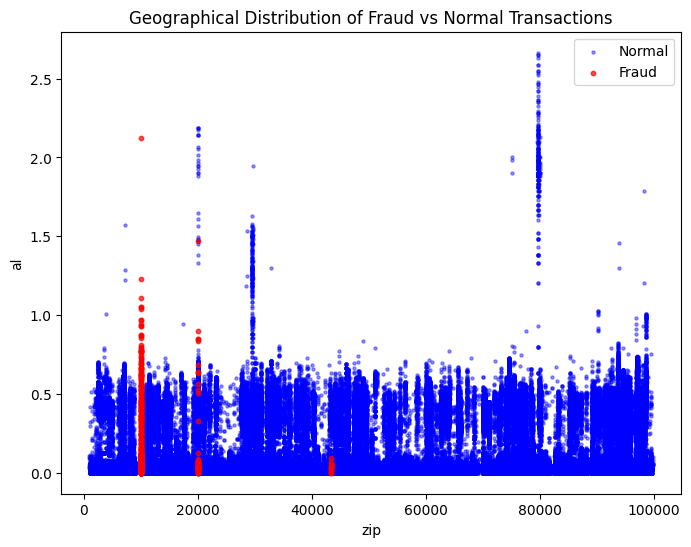

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df[df['is_fraud']==0]['zip'], df[df['is_fraud']==0]['al'],
            s=5, alpha=0.4, label='Normal', color='blue')
plt.scatter(df[df['is_fraud']==1]['zip'], df[df['is_fraud']==1]['al'],
            s=10, alpha=0.7, label='Fraud', color='red')
plt.xlabel('zip')
plt.ylabel('al')
plt.title('Geographical Distribution of Fraud vs Normal Transactions')
plt.legend()
plt.show()


In [30]:
import folium

# 建立地圖中心（以資料平均位置為中心）
center_lat = df['latitude'].mean()
center_lon = df['longitude'].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=6)

# 加入交易點
for _, row in df.iterrows():
    color = 'red' if row['is_fraud'] == 1 else 'blue'
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        color=color,
        fill=True,
        fill_opacity=0.5
    ).add_to(m)

m.save('fraud_map.html')


KeyboardInterrupt: 

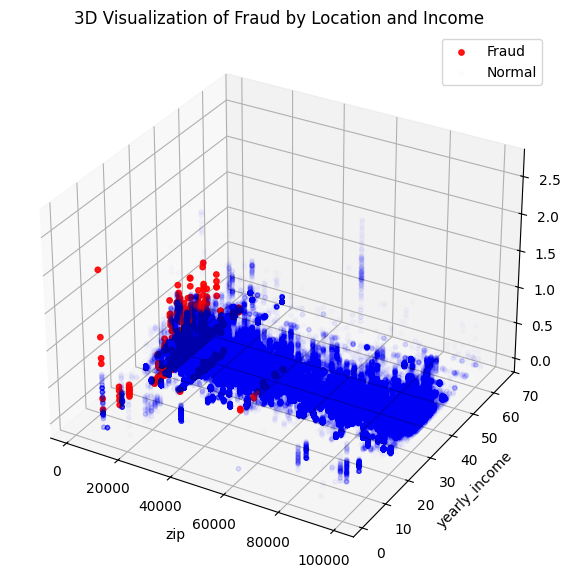

In [57]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

df["al"]=df['amount']/df["credit_limit"]

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# 各類別上色
# 先畫 Fraud
ax.scatter(
           df[df['is_fraud']==1]['zip'],
          
           df[df['is_fraud']==1]['yearly_income'],
           df[df['is_fraud']==1]['al'],
           c='red', label='Fraud', alpha=0.9, s=15)

# 再畫 Normal
ax.scatter(
           df[df['is_fraud']==0]['zip'],
           
           df[df['is_fraud']==0]['yearly_income'],
           df[df['is_fraud']==0]['al'],
           c='blue', label='Normal', alpha=0.01, s=10)


ax.set_xlabel('zip')
ax.set_zlabel('al')
ax.set_ylabel('yearly_income')
ax.set_title('3D Visualization of Fraud by Location and Income')
ax.legend()
plt.show()


In [52]:
df["al"]=df['amount']/df["credit_limit"]

In [58]:
df["zip"]==10000

12845534     True
12895409    False
12646582    False
11626175    False
12218212    False
            ...  
11247464    False
12403412    False
10870934    False
12465326    False
11940857    False
Name: zip, Length: 1369550, dtype: bool

In [62]:
fraud = df[df["is_fraud"] == 1]

# 99_其他code

In [9]:
merged.to_csv("merged.csv", index=False)